In [38]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import warnings
import os
warnings.filterwarnings('ignore')
chdir = True

### DATA

In [39]:
if chdir:
    os.chdir('../db/')
    chdir = False
os.getcwd()

'/Users/mini/TS/db'

In [40]:
twotci = pd.read_parquet("tw/ind/TWOTCI.parquet").iloc[:, :-1]
twotci['ticker'] = "TWOTCI"
twse = pd.read_parquet("tw/ind/TWSE.parquet")
twse['ticker'] = "TWSE"
df = pd.concat([twse, twotci], axis=0)

filtered_df = df.copy()
filtered_df['AvgPrice'] = (filtered_df['high'] + filtered_df['low']) / 2
filtered_df['Return'] = filtered_df.groupby('ticker')['AvgPrice'].pct_change()
filtered_df['beta'] = filtered_df.groupby('ticker')['close'].pct_change().shift(-1)

def rolling_std(group):
    group['return_stddev'] = group['Return'].rolling(window=5).std() * 100
    return group

filtered_df = filtered_df.groupby('ticker').apply(rolling_std).reset_index(level='ticker', drop=True)

def calculate_moving_averages(df):
    df['MA20'] = df['close'].rolling(window=20).mean()
    df['MA60'] = df['close'].rolling(window=60).mean()
    return df

filtered_df = filtered_df.groupby('ticker').apply(calculate_moving_averages).reset_index(level='ticker', drop=True)
start_date = '2015-01-01'
twse = filtered_df[(filtered_df['ticker'] == 'TWSE') & (filtered_df.index >= start_date)][['close', 'AvgPrice', "Return", "beta", "return_stddev", "MA20", "MA60"]]
twotci = filtered_df[(filtered_df['ticker'] == 'TWOTCI') & (filtered_df.index >= start_date)][['close', 'AvgPrice', "Return", "beta", "return_stddev", "MA20", "MA60"]]
twotci.reset_index(inplace=True)
twotci['da'] = pd.to_datetime(twotci['da'])
twse.reset_index(inplace=True)
twse['da'] = pd.to_datetime(twse['da'])

In [41]:
twse

,da,close,AvgPrice,Return,beta,return_stddev,MA20,MA60
0,2015-01-05,9274.11,9237.165,-0.004593,-0.024344,0.432269,9106.9020,8985.138167
1,2015-01-06,9048.34,9126.685,-0.011960,0.003509,0.704103,9099.9545,8990.754000
2,2015-01-07,9080.09,9079.600,-0.005159,0.017394,0.569175,9097.5140,8995.949000
3,2015-01-08,9238.03,9200.325,0.013296,-0.002430,0.935220,9107.8075,9005.657667
4,2015-01-09,9215.58,9250.075,0.005407,-0.004045,0.993707,9117.9330,9015.355833
...,...,...,...,...,...,...,...,...
2335,2024-08-01,22642.10,22558.635,0.017034,-0.044343,1.854384,23236.7765,22341.362333
2336,2024-08-02,21638.09,21888.710,-0.029697,-0.083520,1.901650,23160.0595,22357.771667
2337,2024-08-05,19830.88,20383.210,-0.068780,0.033793,3.373305,22975.4770,22343.277833
2338,2024-08-06,20501.02,20207.120,-0.008639,0.038742,3.385906,22822.6985,22342.282000


### Backtest

In [42]:
import numpy as np
def calculate_twotci_metrics(row):
    date = row['da']
    twotci_today = twotci[twotci['da'] == date]
    twotci_next = twotci[twotci['da'] > date].sort_values(by='da').head(1)

    if not twotci_today.empty and not twotci_next.empty:
        twotci_beta = twotci_next['close'].values[0] / twotci_today['close'].values[0] - 1
    else:
        twotci_beta = np.nan
    
    twotci_return_stddev = twotci[(twotci['da'] >= (pd.to_datetime(date) - pd.Timedelta(days=5))) & (twotci['da'] <= date)]['Return'].std() * 100
    twotci_ma20 = twotci[twotci['da'] <= date].sort_values(by='da', ascending=False).head(20)['close'].mean()
    twotci_ma60 = twotci[twotci['da'] <= date].sort_values(by='da', ascending=False).head(60)['close'].mean()
    twotci_cl = twotci_today['close'].values[0] if not twotci_today.empty else np.nan
    
    return pd.Series([twotci_beta, twotci_return_stddev, twotci_ma20, twotci_ma60, twotci_cl])

final_df = twse.copy()
final_df[['TWOTCI_BETA', 'TWOTCI_RETURN_STDDEV', 'TWOTCI_MA20', 'TWOTCI_MA60', 'TWOTCI_CL']] = final_df.apply(calculate_twotci_metrics, axis=1)
final_df.set_index('da', inplace=True, drop=False)

In [43]:
# 4 dimensions, used for factor timing
'''四種分別是
上市漲 上櫃漲
上市漲 上櫃跌
上市跌 上櫃漲
上市跌 上櫃跌
'''

real_exposure = []
final_df['TWOTCI_RETURN_STDDEV_PREV'] = final_df['TWOTCI_RETURN_STDDEV'].shift(1)
for index, row in final_df.iterrows():
    if row['TWOTCI_RETURN_STDDEV'] <= 3 and row['TWOTCI_CL'] > row['TWOTCI_MA20']:
        real_exposure.append(1)
    elif row['TWOTCI_RETURN_STDDEV'] <= 1 or row['return_stddev'] >= 3.5:
        real_exposure.append(1)
    elif (row['TWOTCI_RETURN_STDDEV']-row['TWOTCI_RETURN_STDDEV_PREV']) > 0.5 and row['TWOTCI_CL'] > row['TWOTCI_MA60'] and row['TWOTCI_CL'] < row['TWOTCI_MA20']:
        real_exposure.append(1)
    else:
        real_exposure.append(0)
final_df['signal_ed'] = real_exposure

In [44]:
import yfinance as yf
tsm = yf.download("TSM", start='2016-01-01', progress=False)

In [45]:
final_df['TSM_op'] = tsm['Open']
final_df['TSM_cl'] = tsm['Close']
final_df['pct_change'] = final_df['TSM_cl'].pct_change().shift(-1) # 當天買入index
final_df 

,da,close,AvgPrice,Return,beta,return_stddev,MA20,MA60,TWOTCI_BETA,TWOTCI_RETURN_STDDEV,TWOTCI_MA20,TWOTCI_MA60,TWOTCI_CL,TWOTCI_RETURN_STDDEV_PREV,signal_ed,TSM_op,TSM_cl,pct_change
da,,,,,,,,,,,,,,,,,,
2015-01-05,2015-01-05,9274.11,9237.165,-0.004593,-0.024344,0.432269,9106.9020,8985.138167,-0.016991,NaN,140.660000,140.660000,140.66,NaN,0,NaN,NaN,NaN
2015-01-06,2015-01-06,9048.34,9126.685,-0.011960,0.003509,0.704103,9099.9545,8990.754000,-0.000217,0.748582,139.465000,139.465000,138.27,NaN,1,NaN,NaN,NaN
2015-01-07,2015-01-07,9080.09,9079.600,-0.005159,0.017394,0.569175,9097.5140,8995.949000,0.003545,0.574928,139.056667,139.056667,138.24,0.748582,1,NaN,NaN,NaN
2015-01-08,2015-01-08,9238.03,9200.325,0.013296,-0.002430,0.935220,9107.8075,9005.657667,0.001802,0.592627,138.975000,138.975000,138.73,0.574928,1,NaN,NaN,NaN
2015-01-09,2015-01-09,9215.58,9250.075,0.005407,-0.004045,0.993707,9117.9330,9015.355833,-0.004893,0.576034,138.976000,138.976000,138.98,0.592627,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,2024-08-01,22642.10,22558.635,0.017034,-0.044343,1.854384,23236.7765,22341.362333,-0.034206,1.271112,273.416000,264.535500,266.91,1.454767,0,163.479996,158.179993,-0.052598
2024-08-02,2024-08-02,21638.09,21888.710,-0.029697,-0.083520,1.901650,23160.0595,22357.771667,-0.078594,1.312356,272.473500,264.654000,257.78,1.271112,0,151.250000,149.860001,-0.012745
2024-08-05,2024-08-05,19830.88,20383.210,-0.068780,0.033793,3.373305,22975.4770,22343.277833,-0.008462,3.271294,270.484000,264.436167,237.52,1.312356,0,133.860001,147.949997,0.050287


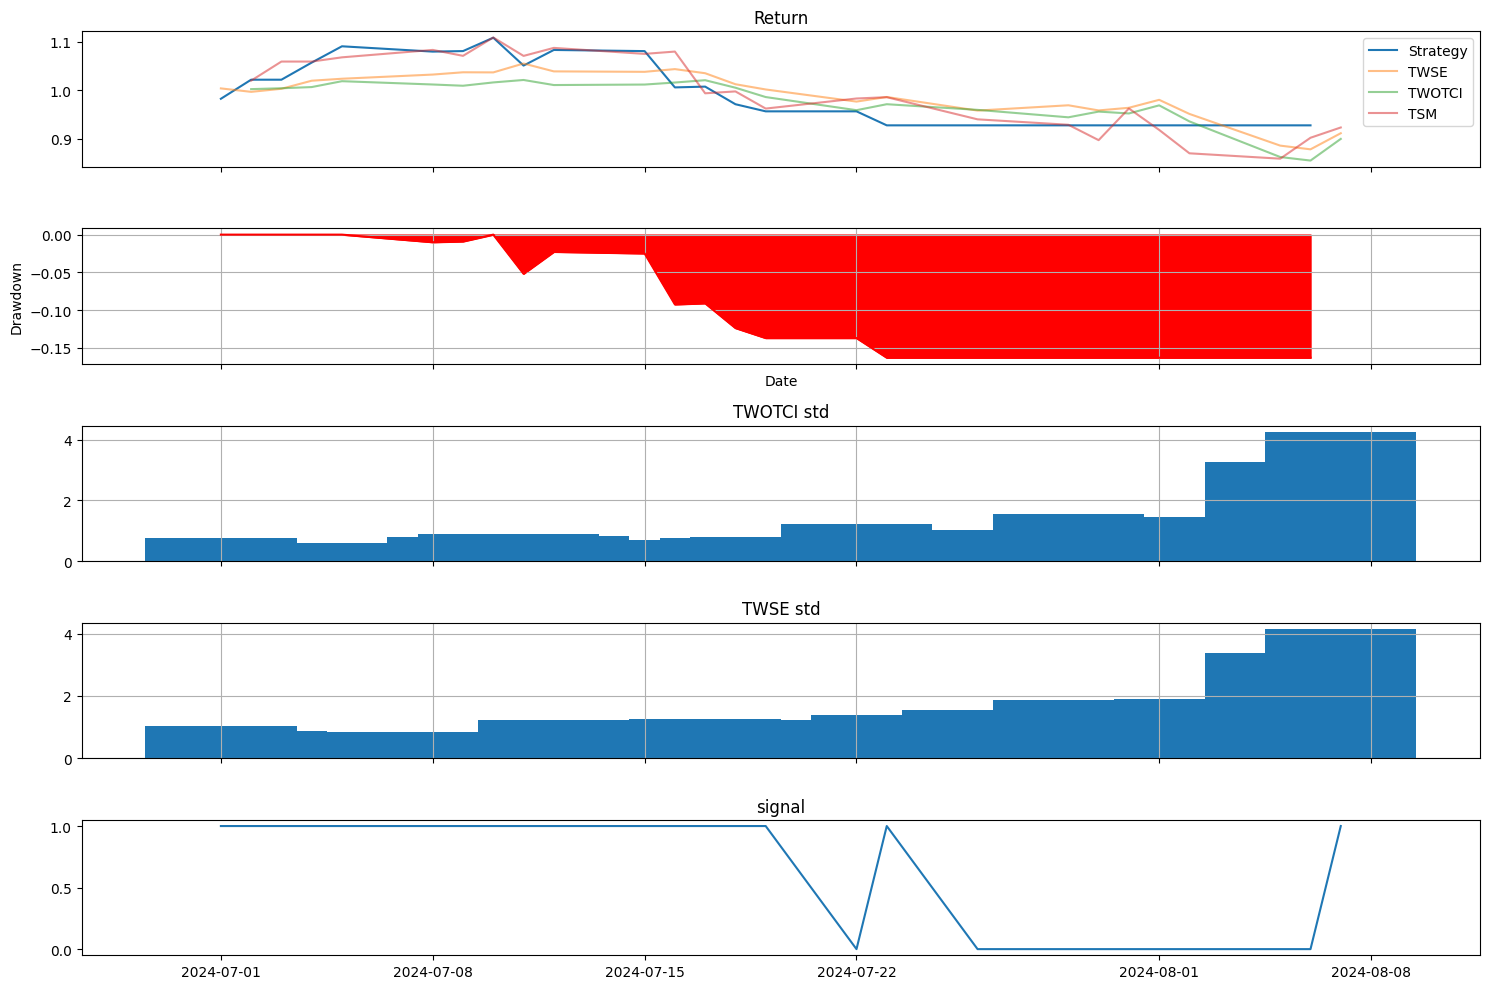

da
2024-08-01    0
2024-08-02    0
2024-08-05    0
2024-08-06    0
2024-08-07    1
Name: signal_ed, dtype: int64

In [48]:
# long short

def calculate_return_on_signal(row, signal_col='final_signal'):
    return row['pct_change'] if row[signal_col] else 0

# ====================
final_df['pct_change'] = final_df['close'].pct_change().shift(-1)

final_df['TSM_op'] = tsm['Open']
final_df['TSM_cl'] = tsm['Close']
final_df['pct_change'] = final_df['TSM_op'].pct_change().shift(-1) # 當天買入index
# ====================

final_df_da = final_df[final_df['da'] >='2024-07-01']
final_df_da['daily_ret_final_signal'] = final_df_da.apply(calculate_return_on_signal, args=("signal_ed",), axis=1)
final_df_da['cumprod_final_signal'] = (1+final_df_da['daily_ret_final_signal']).cumprod()

fig, ax = plt.subplots(5, 1, figsize=(15, 10), sharex=True)
ax[0].plot(final_df_da.index, final_df_da['cumprod_final_signal'], label='Strategy')
ax[0].plot(final_df_da.index, (1+final_df_da['Return']).cumprod(), alpha=0.5, label='TWSE')
ax[0].plot(final_df_da.index, (1+final_df_da['TWOTCI_CL'].pct_change()).cumprod(), alpha=0.5, label='TWOTCI')
ax[0].plot(final_df_da.index, (1+final_df_da['TSM_cl'].pct_change()).cumprod(), alpha=0.5, label='TSM')
ax[0].legend()
ax[0].set_title('Return')
def from_nav_to_mdd(nav_all):
    Roll_Max = nav_all.rolling(len(nav_all), min_periods=1).max()
    Daily_Drawdown = nav_all/Roll_Max - 1.0
    return Daily_Drawdown
    
mdd = from_nav_to_mdd(final_df_da['cumprod_final_signal'])
ax[1].plot(final_df_da.index,mdd, label='Maximum Drawdown', color='red')
ax[1].fill_between(final_df_da.index, mdd, color='red')
ax[1].set_ylabel('Drawdown')
ax[1].set_xlabel('Date')
ax[1].grid()

ax[2].set_title("TWOTCI std")
ax[2].bar(final_df_da.index, final_df_da['TWOTCI_RETURN_STDDEV'],width=5)
ax[2].grid()

ax[3].set_title("TWSE std")
ax[3].bar(final_df_da.index, final_df_da['return_stddev'], width=5)
ax[3].grid()

ax[4].set_title("signal")
ax[4].plot(final_df_da['da'], final_df_da['signal_ed'])

plt.tight_layout()
plt.show()
final_df_da['cumprod_final_signal'].tail()
final_df_da['signal_ed'].tail()

In [47]:
final_df_da['cumprod_final_signal'].tail()


da
2024-08-01    12.255934
2024-08-02    12.255934
2024-08-05    12.255934
2024-08-06    12.255934
2024-08-07          NaN
Name: cumprod_final_signal, dtype: float64